In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from musicautobot.numpy_encode import *
from musicautobot.utils.file_processing import process_all, process_file
from musicautobot.config import *
from musicautobot.music_transformer import *
from musicautobot.multitask_transformer import *
from musicautobot.numpy_encode import stream2npenc_parts

# Generate Music with Pretrained Model

### Load Pretrained

In [4]:
# Config
config = multitask_config();

# Location of your midi files
midi_path =  Path('data/midi')

# Location of saved datset
data_path = Path('data/numpy')
data_save_name = 'musicitem_data_save.pkl'

In [5]:
# Data
data = load_data(data_path, data_save_name, bs=1)
vocab = data.vocab

In [6]:
# # Pretrained Model
# # Download pretrained model if you haven't already
# pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained'
# pretrained_path = untar_data(pretrained_url, dest=data_path)
# load_path = pretrained_path/'MultitaskTransformer.pth'; load_path

In [13]:
files = get_files(Path('data/midi/v19/models/mlm/hook_c'), recurse=True); files

[PosixPath('data/midi/v19/models/mlm/hook_c/refac_4_ep24_nt_best.pth'),
 PosixPath('data/midi/v19/models/mlm/hook_c/refac_2_ep14_best.pth'),
 PosixPath('data/midi/v19/models/mlm/hook_c/refac_4_ep24_nt.pth'),
 PosixPath('data/midi/v19/models/mlm/hook_c/refac_3_ep24_best.pth'),
 PosixPath('data/midi/v19/models/mlm/hook_c/refac_1_ep14.pth'),
 PosixPath('data/midi/v19/models/mlm/hook_c/refac_3_ep24.pth'),
 PosixPath('data/midi/v19/models/mlm/hook_c/refac_1_ep14_best.pth')]

In [15]:

load_path = files[2]; load_path

PosixPath('data/midi/v19/models/mlm/hook_c/refac_4_ep24_nt.pth')

In [16]:
# Learner
learn = multitask_model_learner(data, config.copy(), pretrained_path=load_path)

### Choose existing midi file as a starting point

In [17]:
example_dir = midi_path/'examples'
midi_files = get_files(example_dir, recurse=True, extensions='.mid'); midi_files[:5]

[PosixPath('data/midi/examples/Levels - Avicii - Verse.mid'),
 PosixPath('data/midi/examples/Colors Of The Wind - Disney - Chorus.mid'),
 PosixPath('data/midi/examples/Where Is The Love - Black Eyed Peas - Chorus.mid'),
 PosixPath('data/midi/examples/La Bamba - Ritchie Valen - Chorus.mid'),
 PosixPath('data/midi/examples/I Want You Back - Jackson 5 - Intro.mid')]

In [18]:
file = midi_files[3]; file

PosixPath('data/midi/examples/La Bamba - Ritchie Valen - Chorus.mid')

In [19]:
# Encode file 
item = MusicItem.from_file(file, data.vocab)

x = item.to_tensor()
x_pos = item.get_pos_tensor()

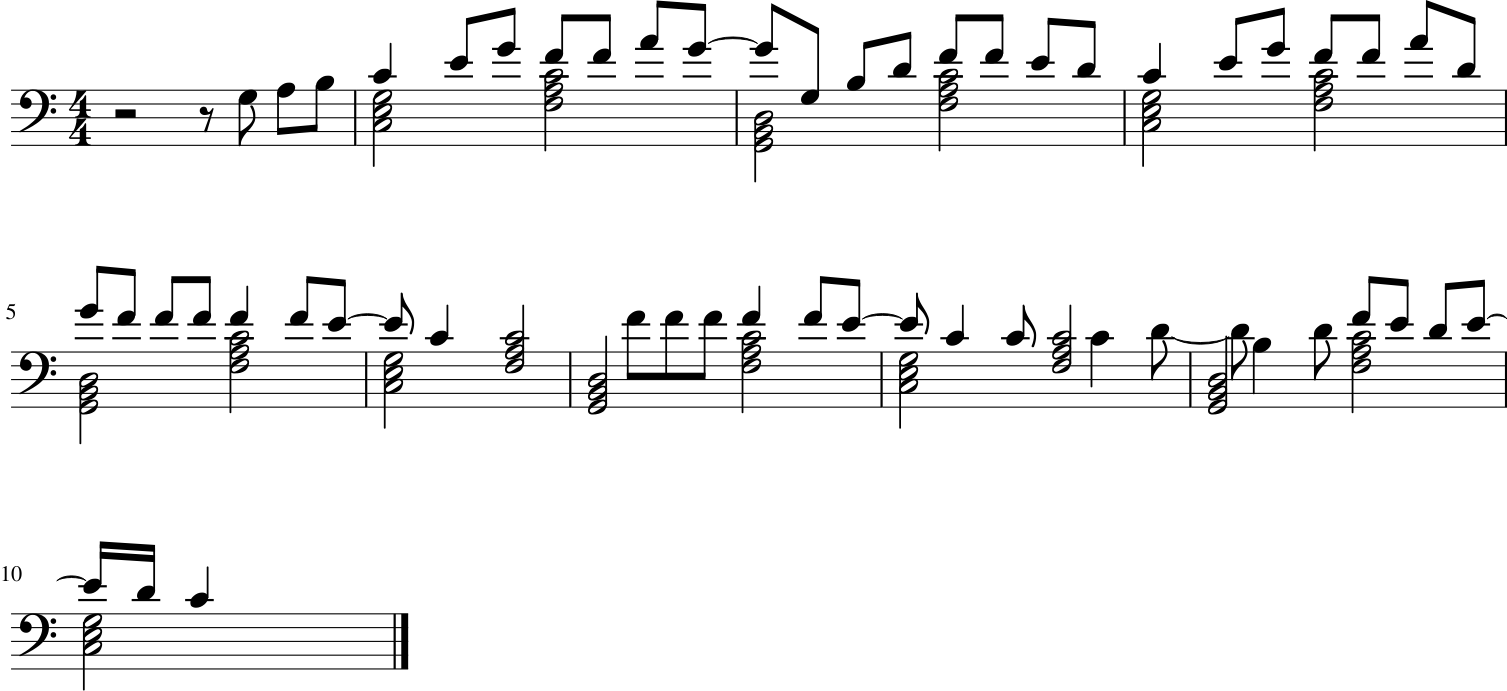

In [20]:
item.show()

In [21]:
item.play()

## Generate

MultitaskTransformer trains on 3 separate tasks. 
1. NextWord
2. Mask
3. Sequence to Sequence

Because we train on 3 separate tasks, we can actually generate some really cool note sequences.

1. NextWord/Autocomplete - Take a sequence of notes and predict the next note
 * 1a. Vanilla Language Model predictions - See [MusicTransformer](../music_transformer) project


2. Mask/Remix - Mask certain parts of song and remix those portions.
 * 2a. Note Masking - Mask all the note pitches and create a new sequence with different notes, but same exact rhythm
 * 2b. Duration Masking - Mask the note durations. Generate a new sequence with the same melody, but with a different rhythm


3. Seq2Seq/Translation - Generate melody from chords or vice versa. 
 * 3a. New Melody - Generate a new melody from existing chords
 * 3b. Harmonization - Generate chords to acompany an existing melody

## 1. NextWord/Autocomplete

Trim the song to only a few notes. Model will use these notes a seed and continue the idea

In [22]:
seed_len = 6 # 4 beats = 1 bar
seed = item.trim_to_beat(seed_len)

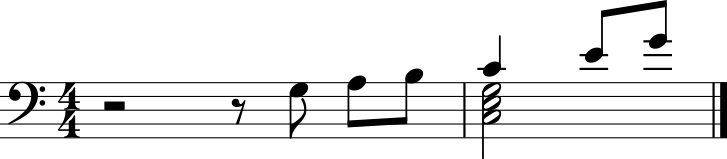

In [23]:
seed.show()

In [24]:
pred_nw = learn.predict_nw(seed, n_words=200)

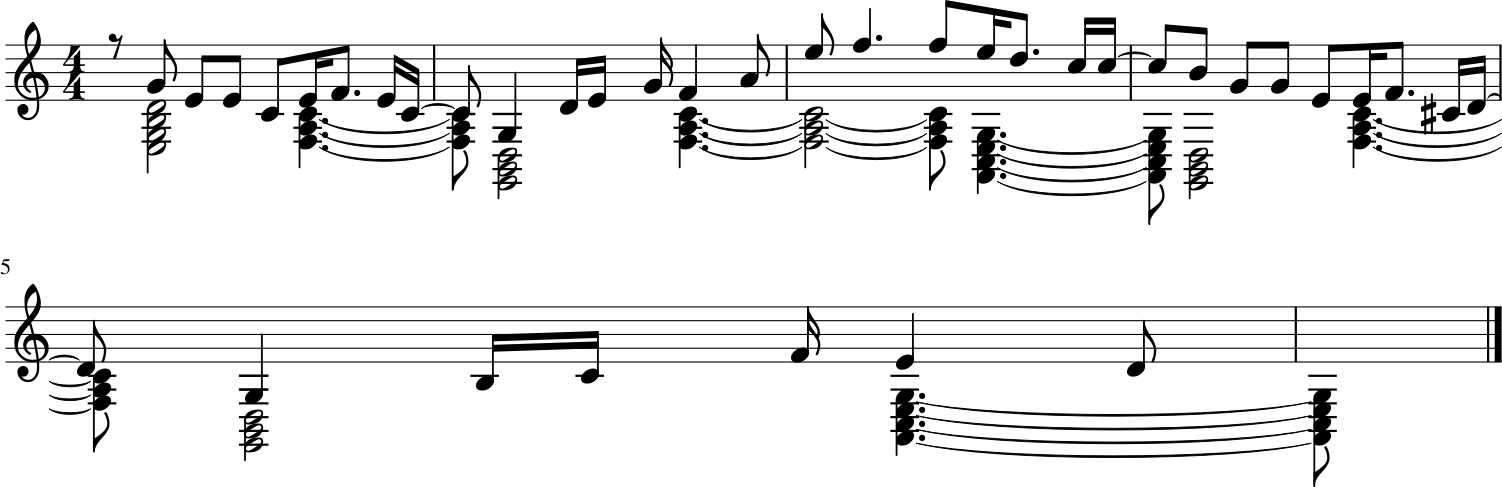

In [25]:
pred_nw.show()

In [26]:
pred_nw.play()

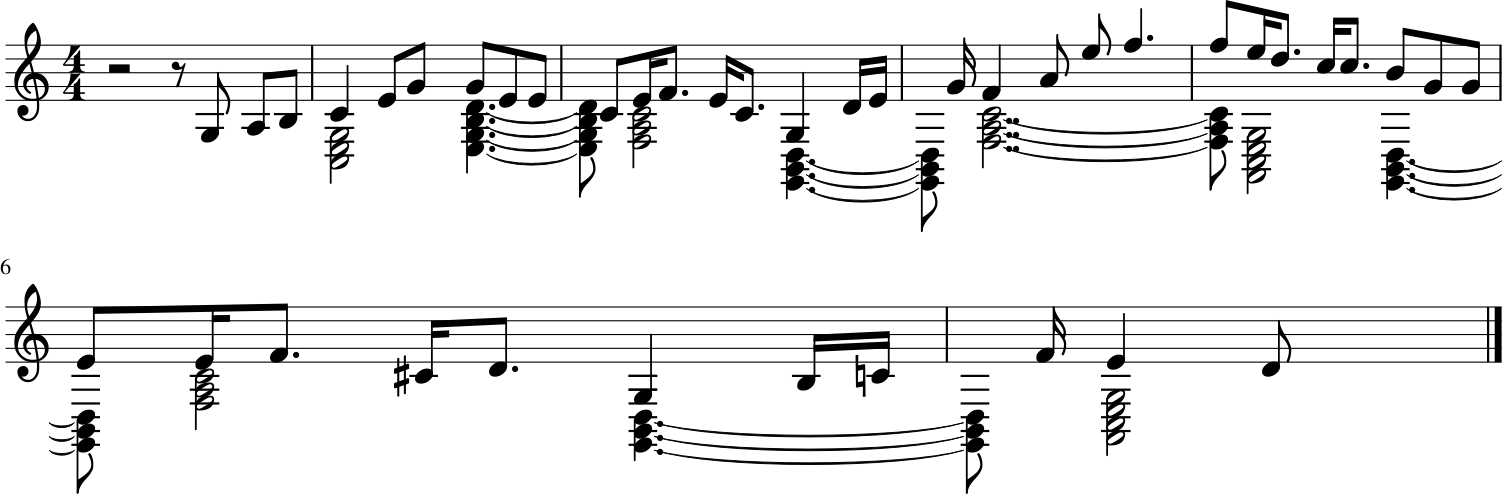

In [28]:
full = seed.append(pred_nw)
full.show()

In [29]:
full.play()

Add more randomness

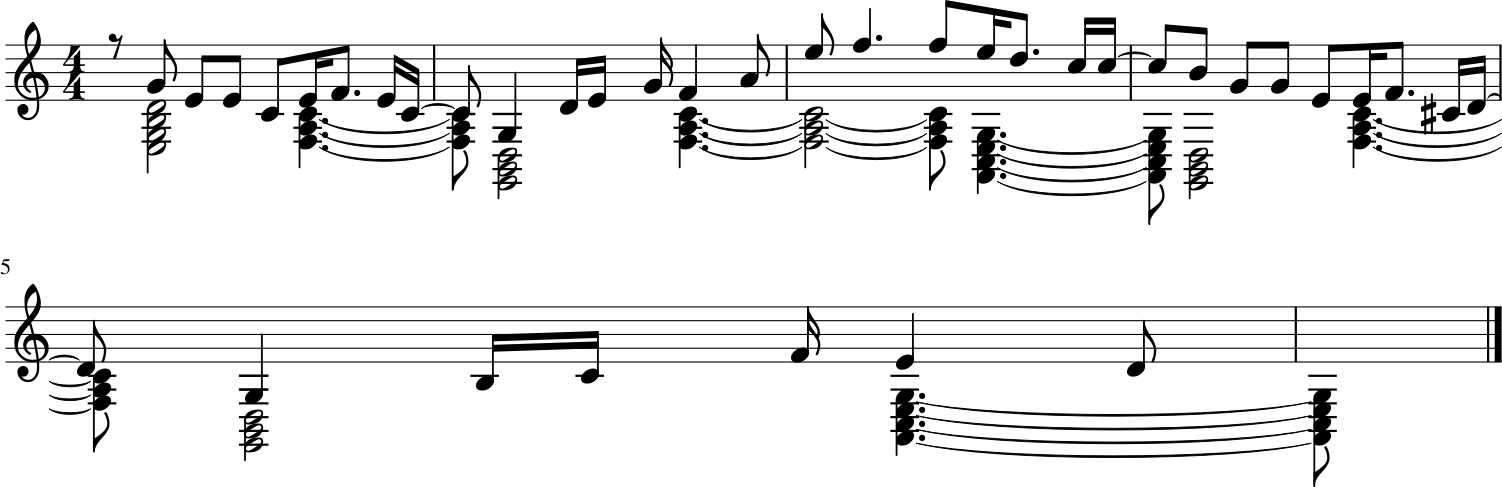

In [30]:
pitch_temp = 1.2 # randomness of melody
tempo_temp = 0.8 # randomness or rhythm
top_k = 40
pred_nw_rand = learn.predict_nw(seed, temperatures=(pitch_temp, tempo_temp), top_k=top_k, top_p=0.5)
pred_nw.show()

In [25]:
# Convenience function
# out = nw_predict_from_midi(learn, file, seed_len=seed_len, top_k=30, top_p=0.5); out.show()

## 2. Mask/Remix

### 2a. Remix Notes

Mask all the note pitches. Model will create a new song with the same rhythm

In [31]:
### Mask notes
note_item = item.mask_pitch();

In [32]:
# Mask vs Original
list(zip(note_item.to_text(None)[:20], item.to_text(None)[:20]))

[('xxbos', 'xxbos'),
 ('xxpad', 'xxpad'),
 ('xxsep', 'xxsep'),
 ('d10', 'd10'),
 ('xxmask', 'n55'),
 ('d2', 'd2'),
 ('xxsep', 'xxsep'),
 ('d2', 'd2'),
 ('xxmask', 'n57'),
 ('d2', 'd2'),
 ('xxsep', 'xxsep'),
 ('d2', 'd2'),
 ('xxmask', 'n59'),
 ('d2', 'd2'),
 ('xxsep', 'xxsep'),
 ('d2', 'd2'),
 ('xxmask', 'n60'),
 ('d4', 'd4'),
 ('xxmask', 'n55'),
 ('d8', 'd8')]

In [43]:
pred_note = learn.predict_mask(note_item)

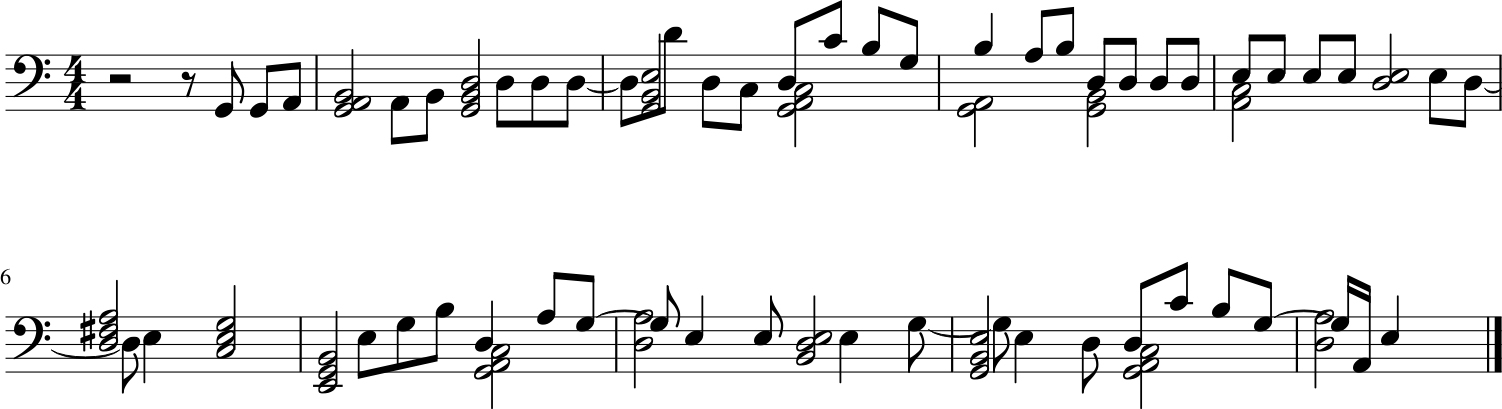

In [44]:
pred_note.show()

In [45]:
pred_note.play()

### 2b. Remix rhythm

Mask note durations. Same notes, different rhythm

In [46]:
# duration mask
dur_item = item.mask_duration()

In [47]:
# Mask vs Original
list(zip(dur_item.to_text(None)[:10], item.to_text(None)[:10]))

[('xxbos', 'xxbos'),
 ('xxpad', 'xxpad'),
 ('xxsep', 'xxsep'),
 ('xxmask', 'd10'),
 ('n55', 'n55'),
 ('xxmask', 'd2'),
 ('xxsep', 'xxsep'),
 ('xxmask', 'd2'),
 ('n57', 'n57'),
 ('xxmask', 'd2')]

In [51]:
dur_pred = learn.predict_mask(dur_item, temperatures=(0.8,0.8), top_k=40, top_p=0.6)

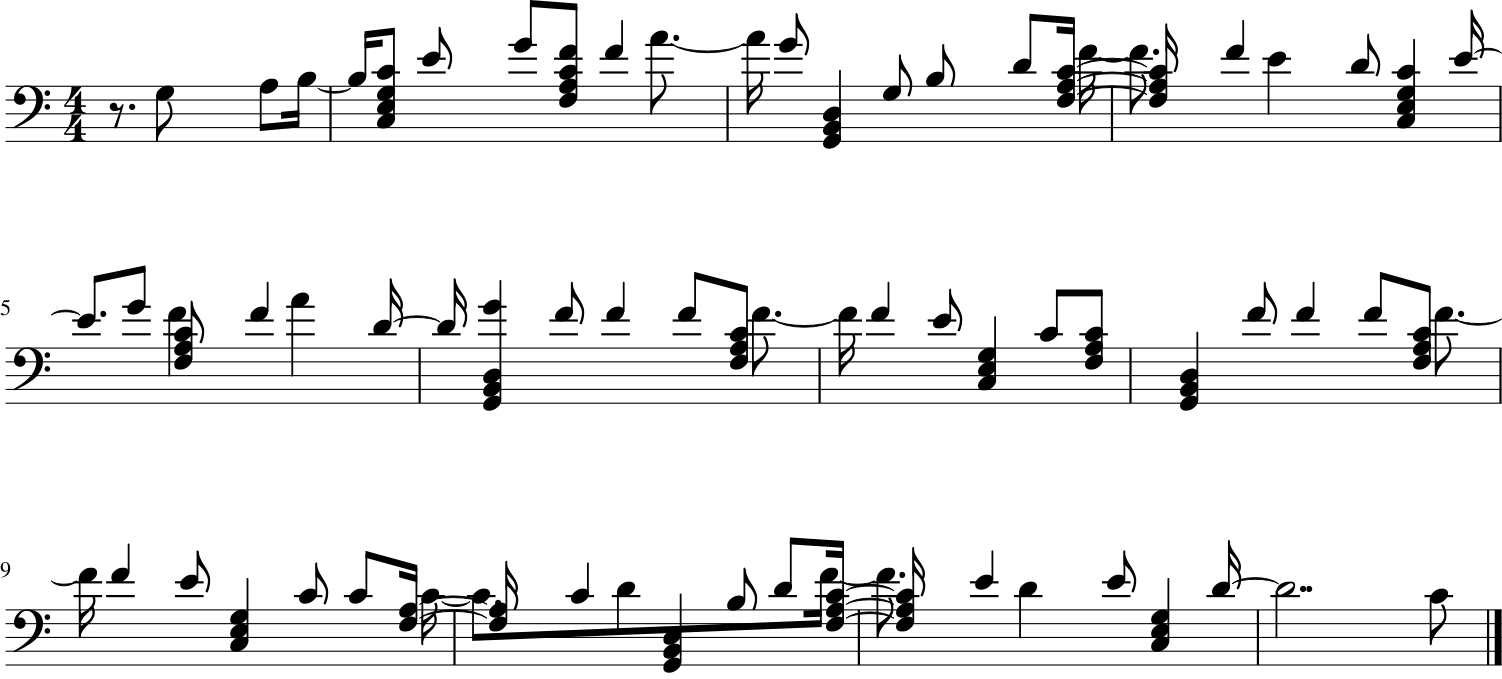

In [52]:
dur_pred.show()

In [53]:
dur_pred.play()

In [29]:
# Convenience function
# out = mask_predict_from_midi(learn, file, predict_notes=True)

## 3. Seq2Seq/Translation

Load MultitrackItem.

MultitrackItem keeps track of which notes are part of the melody and which notes are part of the chords.  
This info is needed for translation task

In [54]:
multitrack_item = MultitrackItem.from_file(file, vocab)

In [55]:
melody, chords = multitrack_item.melody, multitrack_item.chords

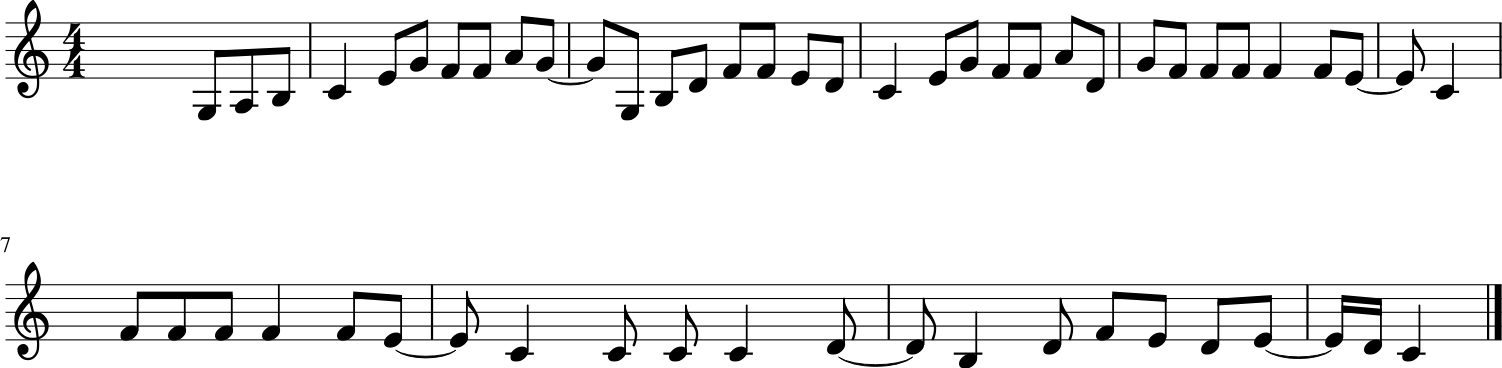

In [56]:
melody.show()

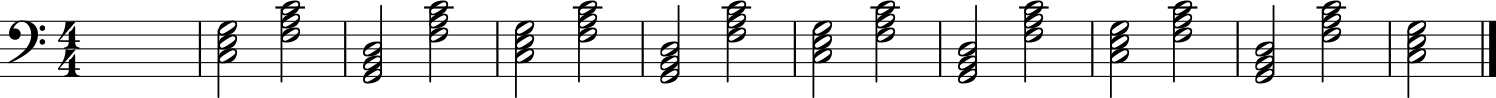

In [57]:
chords.show()

In [58]:
multitrack_item.play()

## 3a. Create Melody

Use existing chord progression to generate a new melody

In [59]:
# Use a seed for the melody
partial_melody = melody.trim_to_beat(4)

# Or generate from an empty sequence
empty_melody = MusicItem.empty(vocab, seq_type=SEQType.Melody)

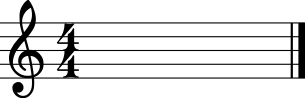

In [60]:
seed_melody = empty_melody; seed_melody.show()

Predicted past counter-part length. Returning early


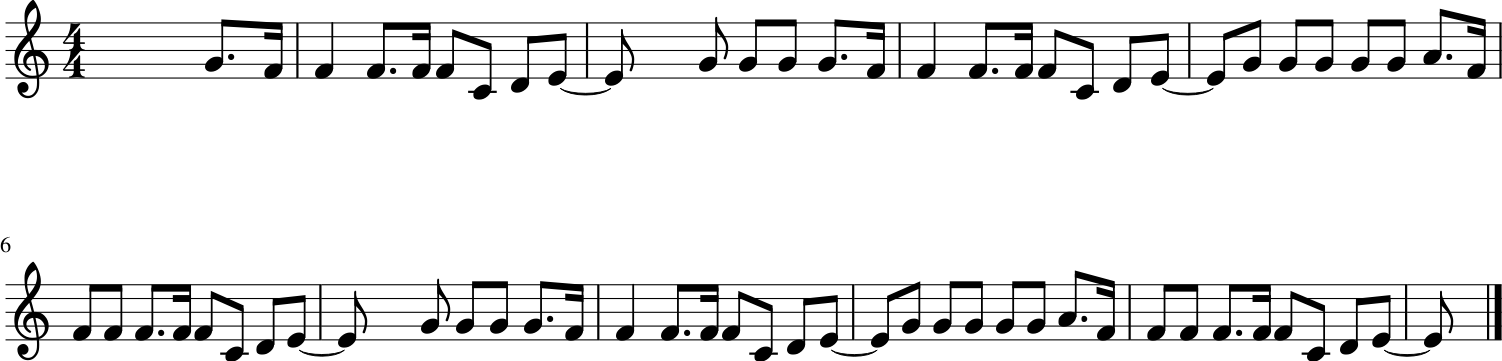

In [61]:
pred_melody = learn.predict_s2s(chords, seed_melody, use_memory=True)
pred_melody.show()

In [62]:
pred_melody.play()

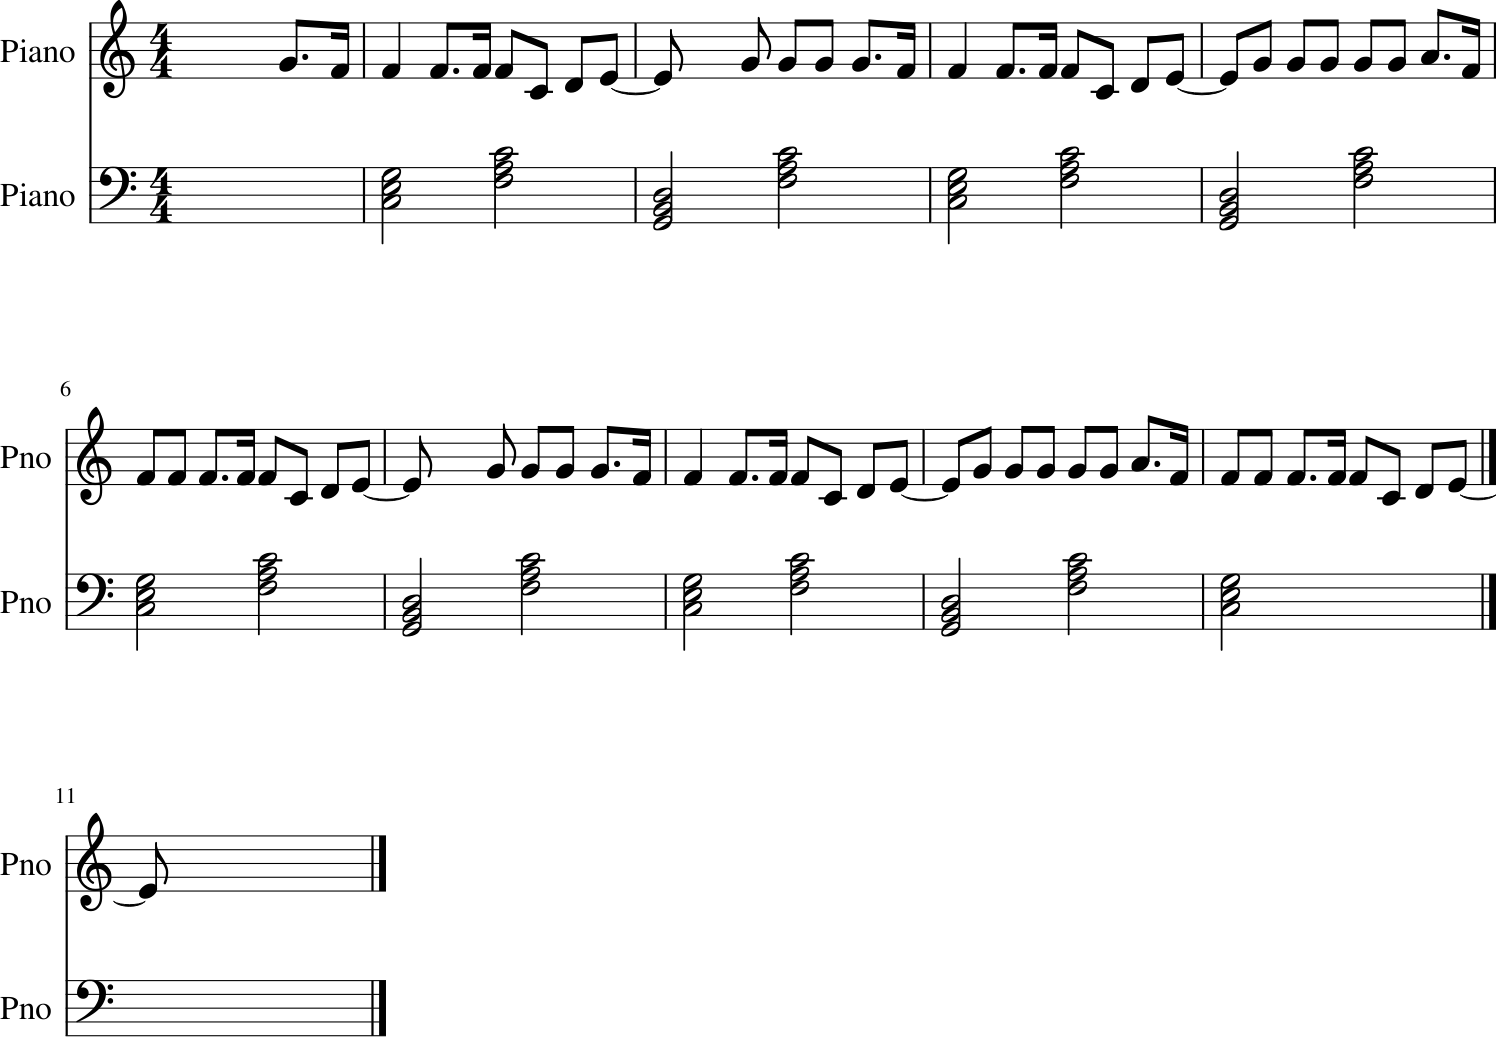

In [63]:
combined = MultitrackItem(pred_melody, chords)
combined.show()

In [64]:
combined.play()

## 3b. Harmonization

Generate chords to accompany an existing melody

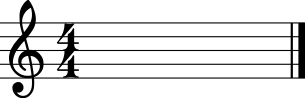

In [79]:
# partial_chords = chords.trim_to_beat(3);
# partial_chords.show()

empty_chords = MusicItem.empty(vocab, seq_type=SEQType.Chords); empty_chords.show()

In [87]:
pred_chord = learn.predict_s2s(input_item=melody, target_item=empty_chords, temperatures=(0.8, 0.8))

Predicted past counter-part length. Returning early


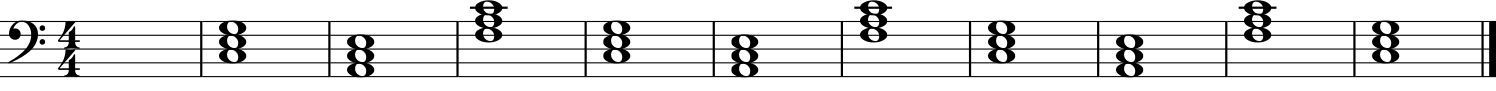

In [88]:
pred_chord.show()

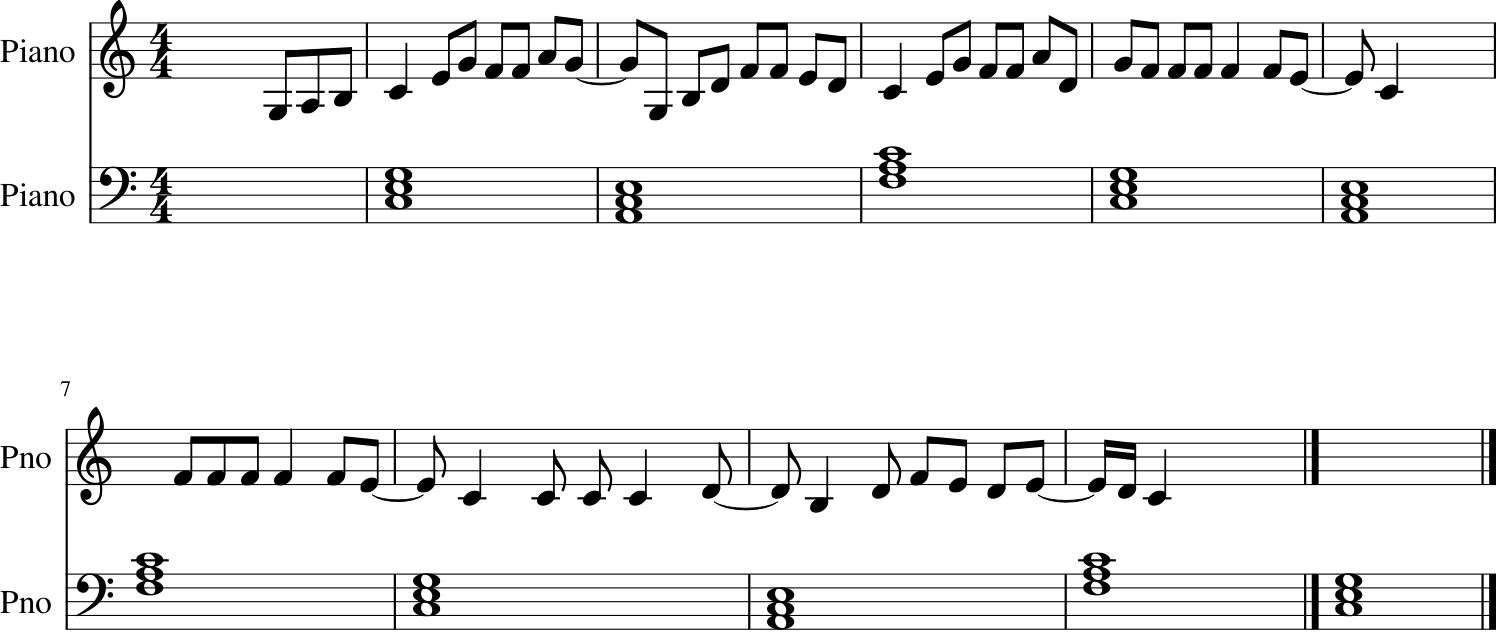

In [89]:
combined = MultitrackItem(melody, pred_chord)
combined.show()

In [90]:
combined.play()

In [45]:
# Convenience Function

# out = s2s_predict_from_midi(learn, file, seed_len=10); out.show()